# Characterizing 3D PSF

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least-squares fitting

%matplotlib inline
import mpld3 #For making nice looking plots
from mpld3 import plugins
mpld3.enable_notebook()
import matplotlib #for plotting and displaying images
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
sys.path.append("Z:\\Code\\BeadTracking\\track") #Locate code
import tiff_file #Ignore any warnings importing this may cause

Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


First, load the data. After acquiring image stacks of immobilized fluorescent beads with widefield and confocal you should crop those stacks so that a single bead is centered with the stack. Save those as tiff files.

In [2]:
data_dir = "Z:\\Code\\PythonCode\\PythonCodeFor381\\python_scripts\\ExampleData\\"
data_file = "FOR_PSF_100x_200nmSteps001_cs001_From0818.tif"

imageStack = tiff_file.imread(data_dir+data_file)
print "Dimensions of stack: ", imageStack.shape

Dimensions of stack:  (31L, 64L, 64L)


Let's find the center of the bead. We'll just locate where the maximum pixel value is using <code>np.argmax</code>.

We'll also use <code>np.unravel_index</code>. What does that do? Look that up in the [numpy documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html) and test what is contained within "<code>brightestPixel</code>". 

In [4]:
brightestPixel = np.argmax(imageStack)
print "Brightest pixel at ", np.unravel_index(brightestPixel, imageStack.shape)

Brightest pixel at  (14, 30, 31)


[]

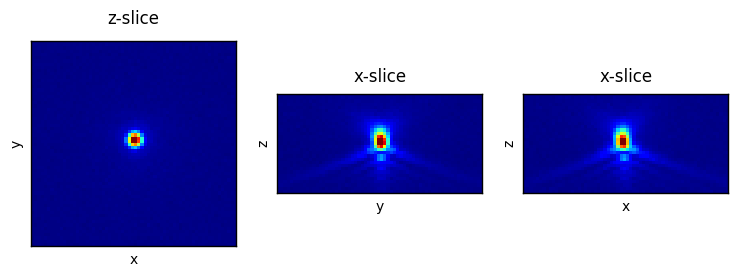

In [8]:
z,x,y = np.unravel_index(brightestPixel, imageStack.shape)
fig,axes = plt.subplots(1,3,figsize=(9,3))
axes[0].matshow(imageStack[z])
axes[0].set_title("z-slice")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[1].matshow(imageStack[:,x,:])
axes[1].set_title("x-slice")
axes[1].set_xlabel("y"); axes[1].set_ylabel("z")
axes[1].set_xticks([]); axes[1].set_yticks([])
axes[2].matshow(imageStack[:,:,y])
axes[2].set_title("y-slice")
axes[2].set_xlabel("x"); axes[2].set_ylabel("z")
axes[2].set_xticks([]); axes[2].set_yticks([])

Sometimes it's easier to examine the PSF if we logarithmically scale the intensity.

[]

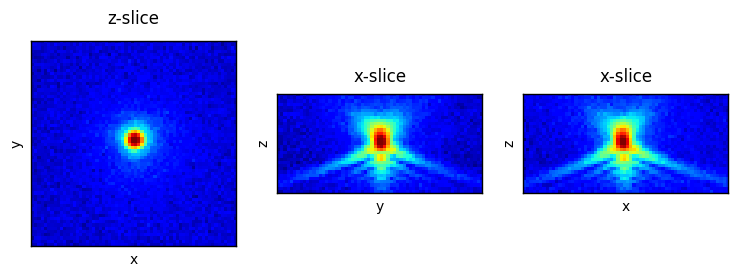

In [9]:
z,x,y = np.unravel_index(brightestPixel, imageStack.shape)
fig,axes = plt.subplots(1,3,figsize=(9,3))
axes[0].matshow(np.log(imageStack[z]))
axes[0].set_title("z-slice")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[1].matshow(np.log(imageStack[:,x,:]))
axes[1].set_title("x-slice")
axes[1].set_xlabel("y"); axes[1].set_ylabel("z")
axes[1].set_xticks([]); axes[1].set_yticks([])
axes[2].matshow(np.log(imageStack[:,:,y]))
axes[2].set_title("x-slice")
axes[2].set_xlabel("x"); axes[2].set_ylabel("z")
axes[2].set_xticks([]); axes[2].set_yticks([])

From the images you should be able to make some intelligent observations about the shape of the PSF, especially in comparison with other microscopy techniques.

Now, let's **quantify** the shape of the PSF.

In [13]:
intensity_profile_along_z = imageStack[:,x,y]

#Using fact that z-stack acquired with step size of 200 nm
distance_in_z = (np.arange(0,imageStack.shape[0])-z) * 0.2

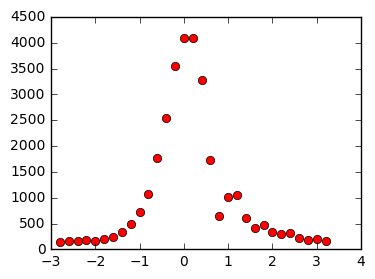

In [14]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(distance_in_z, intensity_profile_along_z,'ro')

We'll fit the above intensity profile to a Gaussian function so that we can quantify the width.

In [15]:
#Define a function that returns a Gaussian
def peakedGauss(params, x):
    '''
    Returns a 1D Gaussian
    '''
    B = params[0] #Noise
    A = params[1] #amplitude
    mu = params[2] #center
    width = params[3]
    expTerm = ((x-mu)/width)**2
    g = B + (A * np.exp(-1*expTerm))
    return g

#Create function to be used in least squares fitting
def errorFunc(params, data, x):
    '''
    Error function for least squares fitting
    '''
    return data-peakedGauss(params,x)

In [29]:
#First specify the initial guess for fitting the intensity profile to a Gaussian
#The paramters are:
#   background (could just use .min() to get minimum value)
#   amplitude (could just use .max() and .min() to get range)
#   center (likely zero if profile is centered about max intensity)
#   width
initGuess = np.array([intensity_profile_along_z.min(),
                     intensity_profile_along_z.max()-intensity_profile_along_z.min(),
                     0,
                     1])
fit_z,flag = leastsq(errorFunc, initGuess, args=(intensity_profile_along_z, distance_in_z))
print "best fit paramters:\n  center: %.3f\n  width: %.3f" % (fit_z[2], fit_z[3])

best fit paramters:
  center: 0.035
  width: 0.626


Let's do the same for intensity profile along *x* and *y*

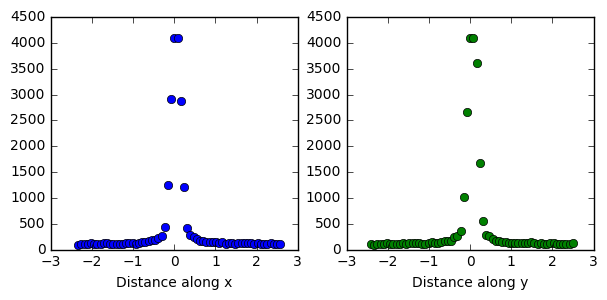

In [30]:
pixelSize = 0.078 #78 nm/pixel
intensity_profile_along_x = imageStack[z,:,y]
distance_in_x = (np.arange(0,imageStack.shape[1])-x) * pixelSize
intensity_profile_along_y = imageStack[z,x,:]
distance_in_y = (np.arange(0,imageStack.shape[2])-y) * pixelSize
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(distance_in_x, intensity_profile_along_x,'bo')
ax[0].set_xlabel("Distance along x")
ax[1].plot(distance_in_y, intensity_profile_along_y,'go')
ax[1].set_xlabel("Distance along y")

In [31]:
initGuess = np.array([intensity_profile_along_x.min(),
                     intensity_profile_along_x.max()-intensity_profile_along_x.min(),
                     0,
                     0.3])
fit_x,flag = leastsq(errorFunc, initGuess, args=(intensity_profile_along_x, distance_in_x))
print "x-profile best fit paramters:\n  center: %.3f\n  width: %.3f" % (fit_x[2], fit_x[3])

initGuess = np.array([intensity_profile_along_y.min(),
                     intensity_profile_along_y.max()-intensity_profile_along_y.min(),
                     0,
                     0.3])
fit_y,flag = leastsq(errorFunc, initGuess, args=(intensity_profile_along_y, distance_in_y))
print "y-profile best fit paramters:\n  center: %.3f\n  width: %.3f" % (fit_y[2], fit_y[3])

x-profile best fit paramters:
  center: 0.038
  width: 0.172
y-profile best fit paramters:
  center: 0.058
  width: 0.178


Let's see how the width compares with the theoretical size of the PSF.

In 1873, Ernst Abbe related to the resolution limit to the numerical aperture of the lens and the wavelength of light. That relationship is engraved on his [tombstone](https://en.wikipedia.org/wiki/Diffraction-limited_system#/media/File:Ernst_Abbe_memorial.JPG).

In [47]:
#What's the wavelength (in microns) of the emitted light
wavelength = 0.525

#What's the numerical aperture of the objective
NA = 1.4

abbe_res_limit_xy = wavelength / (2*NA)
abbe_res_limit_z = (2.0*wavelength) / (NA**2)

print "Resolution limit:\n %.3f in x-y and\n %.3f in z." % (abbe_res_limit_xy, abbe_res_limit_z)

Resolution limit:
 0.188 in x-y and
 0.536 in z.


Let's find the full width at half max (FWHM) of the Gaussian we fit the intensity profiles to. The FWHM isn't precisely the Abbe resolution parameter but is closer.

In [45]:
fwhm_z = np.sqrt(np.log(2))*np.sqrt(fit_z[3])
print "FWHM_z: ", fwhm_z

fwhm_x = np.sqrt(np.log(2))*np.sqrt(fit_x[3])
print "FWHM_x: ", fwhm_x

fwhm_y = np.sqrt(np.log(2))*np.sqrt(fit_y[3])
print "FWHM_y: ", fwhm_y

FWHM_z:  0.658473170292
FWHM_x:  0.345243767368
FWHM_y:  0.351683579374
